In [1]:
import wandb
from datetime import datetime

In [2]:
mask_model_ver = 132508
lr = 5e-4
batch_size = 8
wd = 1e-5
IMAGE_SIZE = 768
backbone='efficientdetv2_dt'
# backbone='efficientdetv2_ds'
vertical_type = "axial"
train_portion = 0.5
milestones = [30, 40, 50]
model_name = "effdet"
epochs = 60

checkpoint = None
# checkpoint = 'axial_detection_effdet_104709-last-54.pth'

In [3]:
wandb_entity='longyi'
model_name = "effdet"
wandb.init(project="YOLOR", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "backbone" : backbone,
    "image_size" : IMAGE_SIZE,
})
wandb.run.name = f'axial_detection_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'axial_detection_effdet_150554'

In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from effdet import create_model
from effdet import DetBenchPredict
# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

import json
# from sklearn.model_selection import GroupKFold

%load_ext autoreload
%autoreload 2

# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95_croped_132508')
MASK_DIR = os.path.join(DATA_DIR, f'segmentation_axial_results_{mask_model_ver}')

BBOX_PATH = os.path.join(DATA_DIR, 'lm_labels/project-6-at-2022-10-25-08-45-4515d287.json')


label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')

In [6]:
with open(BBOX_PATH) as json_file:
    bbox_data = json.load(json_file)
    print(len(bbox_data))

7407


In [7]:
bbox_df = pd.DataFrame()
for data in tqdm(bbox_data):
    image = data['data']['image']
    UID = image.split('/')[-2]
    Slice = image.split('/')[-1].replace('.jpeg','')
    
    if len(data['annotations'][0]['result']) == 0:
        print(f'none result {UID}')
        continue
    bbox = data['annotations'][0]['result'][0]['value']
    
    # coord = [bbox['x'], bbox['y'], bbox['width'], bbox['height']]
    
    new_s = pd.Series(data={
        'UID' : UID,
        'axial_index' : Slice,
        'x' : bbox['x'] * 5.12,
        'y' : bbox['y'] * 5.12,
        'width' : bbox['width'] * 5.12,
        'height' : bbox['height'] * 5.12
    })
    
    bbox_df = pd.concat((bbox_df, new_s.to_frame().T), axis=0)

bbox_df = bbox_df.sort_values(['UID','axial_index']).reset_index(drop=True)
print(len(bbox_df.UID.unique()))
print(len(bbox_df))
bbox_df.tail()

  2%|▏         | 167/7407 [00:00<00:04, 1660.96it/s]

none result 1.2.826.0.1.3680043.13063

  7%|▋         | 503/7407 [00:00<00:04, 1556.64it/s]


none result 1.2.826.0.1.3680043.13063
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037
none result 1.2.826.0.1.3680043.13037


100%|██████████| 7407/7407 [00:05<00:00, 1396.63it/s]

271
7395


,UID,axial_index,x,y,width,height
7390,1.2.826.0.1.3680043.9940,139,297.23186,115.53983,85.18228,66.52623
7391,1.2.826.0.1.3680043.9940,140,298.0,117.0,86.0,61.0
7392,1.2.826.0.1.3680043.9940,141,298.0,119.0,87.0,58.0
7393,1.2.826.0.1.3680043.9940,142,299.0,120.0,89.0,56.0
7394,1.2.826.0.1.3680043.9940,143,299.04425,121.88319,89.71326,53.46549


In [8]:
bbox_df['UID_Slice'] = bbox_df['UID'] + '.' + bbox_df['axial_index'].astype('string')
bbox_df = bbox_df.set_index('UID_Slice').astype({'axial_index': int})
print(len(bbox_df))
bbox_df.head()

7395


,UID,axial_index,x,y,width,height
UID_Slice,,,,,,
1.2.826.0.1.3680043.10051.132,1.2.826.0.1.3680043.10051,132,219.27715,216.71419,17.3044,20.38517
1.2.826.0.1.3680043.10051.133,1.2.826.0.1.3680043.10051,133,221.5646,216.71419,17.87844,25.24362
1.2.826.0.1.3680043.10051.134,1.2.826.0.1.3680043.10051,134,216.82151,221.62546,27.00959,26.37454
1.2.826.0.1.3680043.10051.135,1.2.826.0.1.3680043.10051,135,214.49455,215.48637,27.92726,37.51363
1.2.826.0.1.3680043.10051.136,1.2.826.0.1.3680043.10051,136,214.0,215.48637,27.0,43.51363


In [9]:

total_boundary_df = pd.read_csv(os.path.join(DATA_DIR, f'infered_boundary_{mask_model_ver}_2.csv'))
total_boundary_df['UID_Slice'] = total_boundary_df['StudyInstanceUID'] + '.' + total_boundary_df['Slice'].astype('string')
total_boundary_df = total_boundary_df.set_index('UID_Slice').astype({'Slice': int})
print(len(total_boundary_df))
total_boundary_df.head()

708779


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10001.0,1.2.826.0.1.3680043.10001,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.1,1.2.826.0.1.3680043.10001,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.2,1.2.826.0.1.3680043.10001,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.3,1.2.826.0.1.3680043.10001,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.4,1.2.826.0.1.3680043.10001,4,0,0.253906,0.0,0.0,512.0,512.0


In [10]:
boundary_df = total_boundary_df[total_boundary_df.StudyInstanceUID.isin(bbox_df.UID.unique())]
print(len(boundary_df))
boundary_df.head()

89733


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10051.0,1.2.826.0.1.3680043.10051,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.1,1.2.826.0.1.3680043.10051,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.2,1.2.826.0.1.3680043.10051,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.3,1.2.826.0.1.3680043.10051,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.4,1.2.826.0.1.3680043.10051,4,0,0.253906,0.0,0.0,512.0,512.0


Pick useful columns

In [11]:
train_df = pd.concat((bbox_df[['x','y','width','height']], boundary_df[['xmin','ymin','xmax','ymax','Slice', 'StudyInstanceUID']]), axis=1)
train_df[['new_x', 'new_y']] = train_df[['x','y']].values - train_df[['xmin','ymin']].values
print(len(train_df))
train_df.head()

89733


,x,y,width,height,xmin,ymin,xmax,ymax,Slice,StudyInstanceUID,new_x,new_y
UID_Slice,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,219.27715,216.71419,17.3044,20.38517,43.076729,0.0,436.923271,393.846542,132,1.2.826.0.1.3680043.10051,176.200421,216.71419
1.2.826.0.1.3680043.10051.133,221.5646,216.71419,17.87844,25.24362,36.076729,0.0,429.923271,393.846542,133,1.2.826.0.1.3680043.10051,185.487871,216.71419
1.2.826.0.1.3680043.10051.134,216.82151,221.62546,27.00959,26.37454,45.076729,0.0,438.923271,393.846542,134,1.2.826.0.1.3680043.10051,171.744781,221.62546
1.2.826.0.1.3680043.10051.135,214.49455,215.48637,27.92726,37.51363,41.076729,0.0,434.923271,393.846542,135,1.2.826.0.1.3680043.10051,173.417821,215.48637
1.2.826.0.1.3680043.10051.136,214.0,215.48637,27.0,43.51363,28.076729,0.0,421.923271,393.846542,136,1.2.826.0.1.3680043.10051,185.923271,215.48637


Only pick same size negative cases

In [12]:
cvalue_df = pd.read_csv(os.path.join(DATA_DIR, 'cvalues_for_segmentation_axial_results_132508.csv')).set_index('UID_Slice')
cvalue_df = cvalue_df[cvalue_df.CV > 0]
print(len(cvalue_df))
cvalue_df

455112


,StudyInstanceUID,Slice,CV
UID_Slice,,,
1.2.826.0.1.3680043.10001.153,1.2.826.0.1.3680043.10001,153,0.618027
1.2.826.0.1.3680043.10001.154,1.2.826.0.1.3680043.10001,154,0.657041
1.2.826.0.1.3680043.10001.155,1.2.826.0.1.3680043.10001,155,0.680784
1.2.826.0.1.3680043.10001.156,1.2.826.0.1.3680043.10001,156,0.656002
1.2.826.0.1.3680043.10001.100,1.2.826.0.1.3680043.10001,100,0.248142
...,...,...,...
1.2.826.0.1.3680043.9997.95,1.2.826.0.1.3680043.9997,95,0.343538
1.2.826.0.1.3680043.9997.96,1.2.826.0.1.3680043.9997,96,0.354428
1.2.826.0.1.3680043.9997.97,1.2.826.0.1.3680043.9997,97,0.361016


In [13]:
neg_df = total_boundary_df.loc[cvalue_df.index.unique()]
neg_df = neg_df[neg_df.StudyInstanceUID.isin(label_df[label_df.patient_overall == 0].index.unique())]
print(len(neg_df))
neg_df["x"] = np.nan
neg_df.head()

246897


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax,x
UID_Slice,,,,,,,,,
1.2.826.0.1.3680043.10001.153,1.2.826.0.1.3680043.10001,153,0,0.253906,67.076729,0.076729,460.923271,393.923271,NaN
1.2.826.0.1.3680043.10001.154,1.2.826.0.1.3680043.10001,154,0,0.253906,58.076729,4.076729,451.923271,397.923271,NaN
1.2.826.0.1.3680043.10001.155,1.2.826.0.1.3680043.10001,155,0,0.253906,60.076729,7.076729,453.923271,400.923271,NaN
1.2.826.0.1.3680043.10001.156,1.2.826.0.1.3680043.10001,156,0,0.253906,67.076729,8.076729,460.923271,401.923271,NaN
1.2.826.0.1.3680043.10001.100,1.2.826.0.1.3680043.10001,100,0,0.253906,87.076729,0.000000,480.923271,393.846542,NaN


In [14]:
pos_count = len(train_df[~train_df['x'].isna()])
pos_count

7395

In [15]:
pos_df = train_df[~train_df['x'].isna()]

In [16]:
def crop_image(img:Image, bbox, crop_box):
    """

    :param img:
    :param bbox: [left, top, right, bottom]
    :param crop_box:[left, top, right, bottom]
    :return:
    """
    left, top, right, bottom = crop_box
    img = img.crop(crop_box)
    bbox[0] -= left
    bbox[1] -= top
    bbox[2] -= left
    bbox[3] -= top

    return img, bbox

x                                  290.194946
y                                  232.895307
width                               19.870036
height                              24.490975
xmin                               113.357469
ymin                               141.357469
xmax                               378.642531
ymax                               406.642531
Slice                                     227
StudyInstanceUID    1.2.826.0.1.3680043.24317
new_x                              176.837477
new_y                               91.537838
Name: 1.2.826.0.1.3680043.24317.227, dtype: object


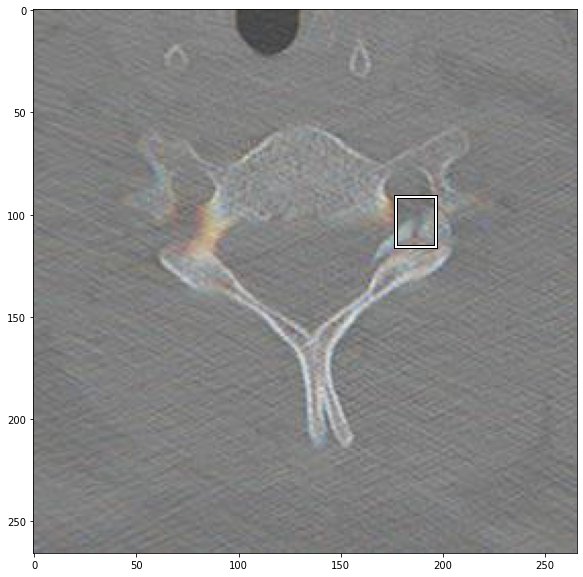

In [17]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()


s = pos_df.loc['1.2.826.0.1.3680043.24317.227']
print(s)
image = Image.open(os.path.join(IMAGES_DIR, s.StudyInstanceUID, f'{int(s.Slice)}.jpeg'))
bbox = list(s[['new_x', 'new_y','width','height']])
bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
crop_box = s[['xmin','ymin','xmax','ymax']]
show_image(image, bbox)

## Dataset

In [18]:
# tf = A.Compose(
#         [
#             A.Transpose(p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.HorizontalFlip(p=0.5),
#             A.RandomBrightness(limit=0.2, p=0.75),
#             A.RandomContrast(limit=0.2, p=0.75),
#             A.OneOf([
#                 A.MotionBlur(blur_limit=5),
#                 A.MedianBlur(blur_limit=5),
#                 A.GaussianBlur(blur_limit=5),
#                 A.GaussNoise(var_limit=(5.0, 30.0)),
#             ], p=0.7),

#             A.OneOf([
#                 A.OpticalDistortion(distort_limit=1.0),
#                 # A.GridDistortion(num_steps=5, distort_limit=1.),
#                 A.ElasticTransform(alpha=3),
#             ], p=0.7),

#             # A.CLAHE(clip_limit=4.0, p=0.7),
#             A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#             A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#             A.Resize(IMAGE_SIZE, IMAGE_SIZE),
#             A.Cutout(max_h_size=int(IMAGE_SIZE * 0.375), max_w_size=int(IMAGE_SIZE * 0.375), num_holes=1, p=0.7),
#                     ToTensorV2(p=1),
#             A.Normalize(0.5, 0.5),
#             ToTensorV2(p=1),
#         ])

In [19]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, mask_dir, pos_df, neg_df):
        self.image_dir = images_dir_path
        self.mask_dir = mask_dir
        self.pos_df = pos_df
        self.neg_df = neg_df

    def __len__(self) -> int:
        return len(self.pos_df) * 2

    def __getitem__(self, idx):
        
        is_pos = (idx % 2) == 0
        
        if is_pos:
            s = self.pos_df.iloc[idx // 2]
        else:
            rand_idx = np.random.randint(0, len(self.neg_df))
            s = self.neg_df.iloc[rand_idx]
        UID = s.StudyInstanceUID
        # print(s)
        axial_index = int(s.Slice)
        img = Image.open(os.path.join(self.image_dir, UID, f"{axial_index}.jpeg"))
        
        
        mask = Image.open(os.path.join(self.mask_dir, UID, f'{axial_index}.png'))
        mask = mask.crop((s.xmin/2, s.ymin/2, s.xmax/2, s.ymax/2))
        
        if pd.isna(s.x):
            pascal_bboxes = []
            class_labels = []
        else:
            pascal_bboxes = [[s.new_x, s.new_y, s.new_x + s.width, s.new_y + s.height]]
            class_labels = np.ones(1)

        return img, pascal_bboxes, class_labels, idx

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, MASK_DIR, pos_df, neg_df)



# 

da[1]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=394x394 at 0x7FC5EB090A60>,
 [],
 [],
 1)

In [20]:
# target_img_size=512
# tf = A.Compose(
#         [
#             A.Transpose(p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.HorizontalFlip(p=0.5),
#             A.RandomBrightness(limit=0.2, p=0.75),
#             A.RandomContrast(limit=0.2, p=0.75),
#             A.OneOf([
#                 A.MotionBlur(blur_limit=5),
#                 A.MedianBlur(blur_limit=5),
#                 A.GaussianBlur(blur_limit=5),
#                 A.GaussNoise(var_limit=(5.0, 30.0)),
#             ], p=0.7),

#             A.OneOf([
#                 A.OpticalDistortion(distort_limit=1.0),
#                 # A.GridDistortion(num_steps=5, distort_limit=1.),
#                 A.ElasticTransform(alpha=3),
#             ], p=0.7),

#             # A.CLAHE(clip_limit=4.0, p=0.7),
#             A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#             A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#             A.Resize(target_img_size, target_img_size),
#             A.Cutout(max_h_size=int(target_img_size * 0.375), max_w_size=int(target_img_size * 0.375), num_holes=1, p=0.7),
#             A.Normalize(0.5, 0.5),
#             ToTensorV2(p=1),
#         ])

# # train_dataset = EfficientDetDataset(da, transforms=tf)
# # img, ann, idx = train_dataset[13]

# # _, axs = plt.subplots(4, 4, figsize=(24, 24))
# for i in range(16):
#     img, pascal_bboxes, class_labels, idx = da[i]
#     # axs[i // 4, i % 4].set_title(f'{np.min(img)} {np.max(img)}')
#     # print(np.array(img, dtype=np.float32).min(), np.array(img, dtype=np.float32).max())
#     img = tf(image=np.array(img, dtype=np.uint8))['image']
#     print(img.min(), img.max())
#     # axs[i // 4, i % 4].set_title(f'{np.min(img)} {np.max(img)}')
#     # axs[i // 4, i % 4].imshow(img / 255, cmap='bone')
    
#     # draw_pascal_voc_bboxes(ax, ann['bboxes'][0].cpu().numpy()[[1, 0, 3, 2]])

## Transform

tensor(-1.) tensor(1.)


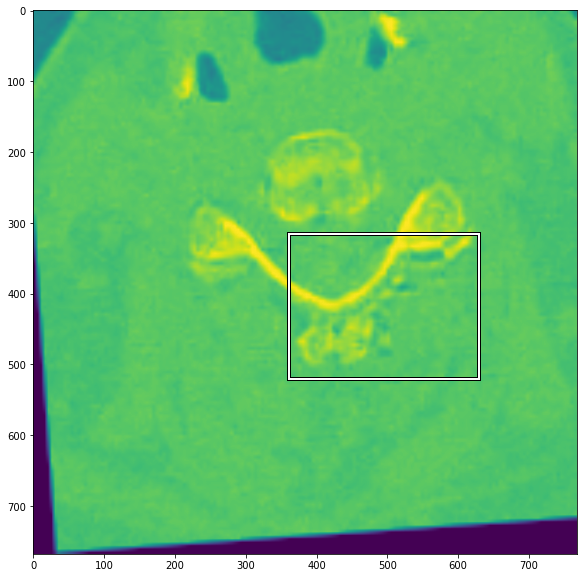

In [21]:
def get_train_transforms(target_img_size=512):
    # return A.Compose(
    #     [
    #         A.ShiftScaleRotate(p=0.5, rotate_limit=15),
    #         A.HorizontalFlip(p=0.5),
    #         A.Resize(height=target_img_size, width=target_img_size, p=1),
    #         A.Normalize(0.5, 0.5),
    #         ToTensorV2(p=1),
    #     ],
    #     p=1.0,
    #     bbox_params=A.BboxParams(
    #         format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
    #     ),
    # )
    return A.Compose(
        [
            # A.Transpose(p=0.5),
            # A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightness(limit=0.2, p=0.75),
            A.RandomContrast(limit=0.2, p=0.75),
            A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.GaussianBlur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
            ], p=0.7),

            # A.OneOf([
            #     A.OpticalDistortion(distort_limit=1.0),
            #     # A.GridDistortion(num_steps=5, distort_limit=1.),
            #     A.ElasticTransform(alpha=3),
            # ], p=0.7),

            # A.CLAHE(clip_limit=4.0, p=0.7),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
            A.Resize(target_img_size, target_img_size),
            A.Cutout(max_h_size=int(target_img_size * 0.25), max_w_size=int(target_img_size * 0.25), num_holes=1, p=0.7),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )



class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=None
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id
        ) = self.ds[index]

        if len(pascal_bboxes) > 0:
            pascal_bboxes = pascal_bboxes[0]
            pascal_bboxes[0] = max(0, pascal_bboxes[0])
            pascal_bboxes[1] = max(0, pascal_bboxes[1])
            pascal_bboxes[2] = min(image.width, pascal_bboxes[2])
            pascal_bboxes[3] = min(image.height, pascal_bboxes[3])
            
            sample = {
                "image": np.array(image, dtype=np.uint8),
                "bboxes": [pascal_bboxes],
                "labels": class_labels,
            }
            sample = self.transforms(**sample)
            sample["bboxes"] = np.array(sample["bboxes"])
            image = sample["image"]
            labels = sample["labels"]

            # print(sample)

            _, new_h, new_w = image.shape
            if len(sample["bboxes"]) > 0:
                sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                                :, [1, 0, 3, 2]
                                                ]  # convert to yxyx

                target = {
                    "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
                    "labels": torch.as_tensor(labels),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
            else:
                target = {
                    "bboxes": torch.zeros((0, 4)),
                    "labels": torch.tensor([]),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
        else:
            # image = image.crop(crop_box)   
            image = self.transforms(image=np.array(image, dtype=np.uint8), bboxes=[], labels=[])["image"]
            _, new_h, new_w = image.shape
            target = {
                "bboxes": torch.zeros((0, 4)),
                "labels": torch.tensor([]),
                "image_id": torch.tensor([image_id]),
                "img_size": (new_h, new_w),
                "img_scale": torch.tensor([1.]),
            }
        
        

        return image, target, image_id

    def __len__(self):
        return len(self.ds)


train_dataset = EfficientDetDataset(da, transforms=get_train_transforms(IMAGE_SIZE))
img, ann, idx = train_dataset[np.random.randint(len(train_dataset))]
# for i in range(16):
#     img, ann, idx = train_dataset[i]
    # print(ann)
    # print(img.shape)
    # print(img.min(), img.max())
print(img.min(), img.max())    
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow((img[2, :, :] * 0.5) + 0.5)

if len(ann['bboxes']) > 0:
    draw_pascal_voc_bboxes(ax, ann['bboxes'][0].cpu().numpy()[[1, 0, 3, 2]])


In [22]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

## Model

In [24]:
# from effdet.config.model_config import efficientdet_model_param_dict
# list(efficientdet_model_param_dict.keys())

In [25]:


def get_det_model(image_size, checkpoint=None):
    if checkpoint is None:

        model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
        model = model.to(device)
        return model
    else:
        model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
        state = torch.load(os.path.join(DATA_DIR, 'checkpoint', checkpoint), map_location=torch.device(device))
        model.load_state_dict(state["model"])
        model = model.to(device)
        return model

model = get_det_model(IMAGE_SIZE, checkpoint)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

13329168


In [26]:
# class_out, box_out = model.model(img.unsqueeze(0).to(device))
# anchors = Anchors.from_config(model.model.config).to(device)
# decode_model_outputs(class_out, box_out, anchors, model.model.config.num_levels)

In [27]:
# val_model = DetBenchPredict(model.model).to(device)
# val_model(img.unsqueeze(0).to(device))

In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [29]:
from evaluate import *
# evaluator = Evaluate(model.model, save_dir=os.path.join(DATA_DIR, 'predictions', wandb.run.name))

# evaluator.evaluate(59)

## Train one epoch

In [30]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (images, anns, _, _) in enumerate(train_iter):
        images = images.to(device)
        anns = {
            'bbox' : [tensor.to(device) for tensor in anns['bbox']],
            'cls' : [tensor.to(device) for tensor in anns['cls']],
            'img_size' : anns['img_size'].to(device),
            'img_scale' : anns['img_scale'].to(device)
        }

        with torch.cuda.amp.autocast(device == 'cuda'):
            losses = model(images, anns)
            loss, class_loss, box_loss = losses['loss'], losses['class_loss'], losses['box_loss']

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step(e + i / epoch_iteration)

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {class_loss.item():.4f} b {box_loss.item():.4f}")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'train_class_loss': class_loss.item(),
                'train_box_loss': box_loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })
            
        
#         if (i + e * epoch_iteration) % 100 == 0:
#             # val_model = DetBenchPredict(model.model).to(device)
#             val_model.eval()
#             val_index = (e * epoch_iteration + i) // 100
#             prediction = evaluate(e, val_model, val_index=val_index)
            
#             model.train()

    return np.mean(loss_list)

In [31]:
# val_UIDs = list(val_df.index.unique())
# len(val_UIDs)

In [32]:
class ValidationDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, mask_path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.mask_path = mask_path
        self.transforms = transforms

        self.len = len(self.df)

    def __getitem__(self, i):

        try:
            s = self.df.iloc[i]
            UID = s.name
            img = Image.open(os.path.join(self.path, UID, f'{int(s.Slice)}.jpeg'))

            mask = Image.open(os.path.join(self.mask_path, UID, f'{int(s.Slice)}.png'))
            
            if self.transforms is not None:
                img, mask = self.transforms(img, mask)
        except Exception as ex:
            print(ex)
            return None, None

        return img, s.pixel_spacing, s.Slice == s.Start, s[['xmin','ymin','xmax','ymax']].values, mask

    def __len__(self):
        return self.len

class ValidationTransform(nn.Module):
    def __init__(self, image_size=512):
        super().__init__()

        self.image_size = image_size

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(0.5, 0.5),
        ])
        
        self.mask_transform = T.Compose([
            T.ToTensor(),
        ])

    def forward(self, x, mask):
        x = self.transform(x)
        mask = self.mask_transform(mask)
        return x, mask
    
# val_tf = ValidationTransform(IMAGE_SIZE)

# UID = '1.2.826.0.1.3680043.10001'
# evaluate_df = val_df.loc[UID].sort_values('Slice')
# # evaluate_df.iloc[0]
# # print(evaluate_df)
# val_ds = ValidationDataSet(evaluate_df, IMAGES_DIR, MASK_DIR, transforms=val_tf)
# # val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(batch_size, 16))

# # iter_d = iter(val_loader)
# # next(iter_d)
# # next(iter_d)
# # next(iter_d)
# img, pixel_spacing, is_end, bbox, mask = val_ds[138]
# print(img.shape, bbox.shape, mask.shape)
# print(mask.min(), mask.max())
# print(bbox)
# _, axs = plt.subplots(1, 2)
# axs[0].imshow(img[0, :, :])
# axs[1].imshow(mask[0, :, :])

In [33]:
def get_bbox_class(seg, bbox):
    """
    label 은 0.125 의 단위로, 
    seg: H x W
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox.int()
    area = seg[ymin:ymax, xmin:xmax]
    
    # print(area)
    result = torch.mean(area[area>0])
    result = torch.round(result / 0.125)
    
    return result

In [34]:
def get_bbox_class_list(seg_list, seg_bboxes):
    class_list = []
    for i in range(seg_list.shape[0]):
        class_index = get_bbox_class(seg_list[i, :, :], seg_bboxes[i, :])
        class_list.append(class_index)
        
    return torch.stack(class_list)

In [35]:
# val_df.loc['1.2.826.0.1.3680043.10001'].sort_values('Slice')

In [36]:


# def crop_resize_images(imgs_tensor, boundary_list, img_size=512):
#     croped_list = []
#     for i in range(imgs_tensor.shape[0]):
#         xmin, ymin, xmax, ymax = boundary_list[i, :]
#         xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
#         # print(xmin, ymin, xmax, ymax)
#         croped = TF.crop(imgs_tensor[i, :, :, :], top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
#         croped = TF.resize(croped, (img_size, img_size))
#         croped_list.append(croped)
        
#     return torch.stack(croped_list, 0)

# def predict_det(x, model):
    
#     bboxes = model(x) # N x 1 x 6
    
#     return bboxes[:, 0, :]

# def get_original_bbox(bbox, boundary, image_size):
#     scale = image_size / (boundary[:, [2]] - boundary[:, [0]])
    
#     org_bbox = bbox / scale
#     org_bbox[:, 0] += boundary[:, 0]
#     org_bbox[:, 1] += boundary[:, 1]
#     org_bbox[:, 2] += boundary[:, 0]
#     org_bbox[:, 3] += boundary[:, 1]
    
#     return org_bbox

# def get_class_score(scores, class_list, eps=1e-2):
#     result = scores.new_zeros((scores.shape[0], 8)) + eps
#     class_list = torch.nan_to_num(class_list).long()
#     result[torch.arange(scores.shape[0]), class_list] = scores
    
#     return result

# def cal_loss(prob, label):
    
#     pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
#     neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
#     score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
#     weight_total = pos_weight * label + neg_weight * (1 - label)
    
#     return -score.sum() / weight_total.sum()


# # table_columns=['UID', 'loss', 'Predictions','Labels']
# # evaluate_table = wandb.Table(data=[], columns=table_columns)

# def log_prediction(UID, prediction):
#     # log
    
    
#     label = label_df.loc[UID].values
#     loss = cal_loss(prediction, label)
   
#     # my_data = [UID, loss, prediction, label]
    
#     # evaluate_table.add_data(*my_data)
    
#     wandb.run.log({
#         # 'evaluate_table' : evaluate_table
#         'eval_sample_UID' : int(UID.split('.')[-1]),
#         'eval_sample_loss' : loss,
#     })
    


# def evaluate(e, det_model, UID=None, val_index=None):
    
#     if UID is None:
#         UID = val_UIDs[val_index]
    
#     with torch.no_grad():
#         evaluate_df = val_df.loc[UID].sort_values('Slice')
#         # print(evaluate_df)
#         val_ds = ValidationDataSet(evaluate_df, IMAGES_DIR, MASK_DIR,val_tf)
#         val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(batch_size, 16))

#         predictions = []
#         x0 = val_ds[0][0]
#         x1 = val_ds[1][0]
#         x0, x1 = x0.to(device), x1.to(device)
#         prev2 = torch.stack((x0, x1))

#         for x, pixel_spacings, is_starts, axial_boundary, seg_result in val_loader:
#             x = x.to(device)
            

#             # (N+2), 1, 512, 512
#             x = torch.cat((prev2, x), dim=0)

#             r = x[:-2, :, :, :]
#             g = x[1:-1, :, :, :]
#             b = x[2:, :, :, :]

#             start_indices = torch.argwhere(is_starts)
#             r[start_indices, :, :, :] = b[start_indices, :, :, :]
#             g[start_indices, :, :, :] = b[start_indices, :, :, :]

#             prev2 = b[-2:, :, :, :]

#             x = torch.cat((r, g, b), dim=1)

#             batch_probs = x.new_zeros((x.shape[0], 8)) + 1e-2

#             seg_result = seg_result.to(device)
#             # seg_areas = seg_result.count_nonzero(dim=[1, 2, 3]) / (256 * 256)

#             # active_indices = torch.argwhere(seg_areas > 0.001)
#             active_indices = seg_result.nonzero()[:, 0].unique()

#             if active_indices.numel() == 0:
#                 predictions.append(batch_probs.cpu())
#                 continue

#             axial_boundary, seg_result = axial_boundary.to(device), seg_result.to(device)
#             active_indices = active_indices.reshape(-1)

#             if active_indices.numel() != batch_size:
#                 x = x[active_indices, :, :, :]
#                 seg_result = seg_result[active_indices, :, :, :]
#                 pixel_spacings = pixel_spacings[active_indices]
#                 axial_boundary = axial_boundary[active_indices]
                


#             # axial_boundary = get_axial_boundary(seg_result, pixel_spacings, seg_img_size=256)  # N x 4, 512 scale

#             x = crop_resize_images(x, axial_boundary, IMAGE_SIZE) # N x 3 x 512 x 512 croped


#             # for det_model in det_models:
#             det_result = predict_det(x, det_model)
#             bboxes, scores = get_original_bbox(det_result[:, :4], axial_boundary, IMAGE_SIZE), det_result[:, 4]
#             class_list = get_bbox_class_list(seg_result[:, 0, :, :], bboxes / (IMAGE_SIZE / 256.))
#             probs = get_class_score(scores, class_list) # N x 7

#             batch_probs[active_indices, :] = probs
#             # print(probs)
#             predictions.append(batch_probs.cpu())

#         predictions = torch.concat(predictions)
      
#         # predictions[:, 0] = torch.amax(predictions, dim=1)
#         prediction = predictions.amax(dim=0)
#         prediction[0] = prediction[1:].amax()
#         # print(predictions)
#         # return predictions
        
        
#         if wandb.run is not None:
#             log_prediction(UID, prediction.numpy())
        
        
#         return prediction

# val_model = DetBenchPredict(model.model).to(device)
# val_model = val_model.eval()
# prediction = evaluate(0, val_model)
# prediction

In [37]:
def save_state(epoch):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))


In [38]:
epoch = 0


In [39]:
# IMAGE_SIZE

In [40]:
from evaluate import *
evaluator = Evaluate(model.model, save_dir=os.path.join(DATA_DIR, 'predictions', wandb.run.name), image_size=IMAGE_SIZE )

loss, pos_loss, neg_loss, batch_index = evaluator.evaluate(epoch)

test df length :  2819


100%|██████████| 177/177 [00:32<00:00,  5.50it/s]

loss :1.0508264209714806 pos_loss:1.352966118525392 neg_loss:0.022188409018360195


In [41]:
# start_batch_index = 0
# for i in range(252):
#     loss, pos_loss, neg_loss, batch_index = evaluator.evaluate(epoch + i + start_batch_index)
#     wandb.log({
#         'val/total_loss': loss,
#         'val/pos_loss': pos_loss,
#         'val/neg_loss': neg_loss,
#         'val/batch_index' : batch_index
#     })

In [42]:
for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    epoch += 1    
    scheduler.step()
    
    with torch.no_grad():
        loss, pos_loss, neg_loss, batch_index = evaluator.evaluate(epoch)
        wandb.log({
            'val/total_loss': loss,
            'val/pos_loss': pos_loss,
            'val/neg_loss': neg_loss,
            'val/batch_index' : batch_index
        }) 
        
        # save_state(epoch)
        
    
        
    if epoch % 10 == 0:
        save_state(epoch)

t 0 loss 1.0952 c 0.6603 b 0.0087: 100%|██████████| 1848/1848 [09:04<00:00,  3.39it/s]  


test df length :  2429


100%|██████████| 152/152 [00:25<00:00,  6.03it/s]


loss :0.5840322662482511 pos_loss:0.3954730447557559 neg_loss:0.44301324602711767


t 1 loss 0.8188 c 0.5228 b 0.0059: 100%|██████████| 1848/1848 [09:01<00:00,  3.41it/s]  


test df length :  3430


100%|██████████| 215/215 [00:33<00:00,  6.33it/s]


loss :0.5822503768340939 pos_loss:0.48255717254797353 neg_loss:0.3893599264152247


t 2 loss 0.9451 c 0.5931 b 0.0070: 100%|██████████| 1848/1848 [09:08<00:00,  3.37it/s]  


test df length :  2621


100%|██████████| 164/164 [00:26<00:00,  6.11it/s]


loss :0.545731979085712 pos_loss:0.4209697257681257 neg_loss:0.3409448827887175


t 3 loss 0.8266 c 0.4651 b 0.0072: 100%|██████████| 1848/1848 [09:02<00:00,  3.41it/s]  


test df length :  2048


100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


loss :0.5736953664818418 pos_loss:0.46441174277001424 neg_loss:0.4411115256952812


t 4 loss 0.5798 c 0.3430 b 0.0047: 100%|██████████| 1848/1848 [08:56<00:00,  3.44it/s]  


test df length :  2473


100%|██████████| 155/155 [00:25<00:00,  6.10it/s]


loss :0.4730494712237423 pos_loss:0.18937084185396583 neg_loss:0.3911228423924895


t 5 loss 0.9147 c 0.5039 b 0.0082: 100%|██████████| 1848/1848 [09:11<00:00,  3.35it/s]  


test df length :  3029


100%|██████████| 190/190 [00:30<00:00,  6.15it/s]


loss :0.5121934345591959 pos_loss:0.2535813537872146 neg_loss:0.44657860863430154


t 6 loss 0.7025 c 0.4198 b 0.0057: 100%|██████████| 1848/1848 [09:09<00:00,  3.36it/s]  


test df length :  3187


100%|██████████| 200/200 [00:34<00:00,  5.77it/s]


loss :0.5195001454104657 pos_loss:0.06755699775690802 neg_loss:0.538394855687128


t 7 loss 0.5842 c 0.3867 b 0.0039: 100%|██████████| 1848/1848 [09:23<00:00,  3.28it/s]


test df length :  2721


100%|██████████| 171/171 [00:30<00:00,  5.56it/s]


loss :0.47706186094457337 pos_loss:0.35344698296713506 neg_loss:0.44967495118699385


t 8 loss 0.6319 c 0.3528 b 0.0056: 100%|██████████| 1848/1848 [09:15<00:00,  3.33it/s] 


test df length :  2526


100%|██████████| 158/158 [00:26<00:00,  5.90it/s]


loss :0.5250075122883777 pos_loss:0.2996488366098399 neg_loss:0.4684212943386622


t 9 loss 0.5848 c 0.3035 b 0.0056: 100%|██████████| 1848/1848 [09:34<00:00,  3.22it/s] 


test df length :  3001


100%|██████████| 188/188 [00:29<00:00,  6.28it/s]


loss :0.5208837128707635 pos_loss:0.3706005805254193 neg_loss:0.4496824485762229


t 10 loss 0.7301 c 0.4867 b 0.0049: 100%|██████████| 1848/1848 [09:24<00:00,  3.27it/s]  


test df length :  2694


100%|██████████| 169/169 [00:28<00:00,  5.91it/s]


loss :0.5984742901722345 pos_loss:0.2358126637072462 neg_loss:0.6494718178023184


t 11 loss 0.4923 c 0.3216 b 0.0034: 100%|██████████| 1848/1848 [09:16<00:00,  3.32it/s]


test df length :  2526


100%|██████████| 158/158 [00:28<00:00,  5.60it/s]


loss :0.4503468566146831 pos_loss:0.23645519375423502 neg_loss:0.4725477960856399


t 12 loss 0.6521 c 0.3918 b 0.0052: 100%|██████████| 1848/1848 [09:05<00:00,  3.39it/s] 


test df length :  2659


100%|██████████| 167/167 [00:28<00:00,  5.84it/s]


loss :0.4505422995297763 pos_loss:0.36116213417111465 neg_loss:0.5567262313297583


t 13 loss 0.4842 c 0.2528 b 0.0046: 100%|██████████| 1848/1848 [08:52<00:00,  3.47it/s]  


test df length :  3048


100%|██████████| 191/191 [00:29<00:00,  6.43it/s]


loss :0.5257040622185565 pos_loss:0.18966115702127453 neg_loss:0.6128031913454427


t 14 loss 0.4729 c 0.3030 b 0.0034: 100%|██████████| 1848/1848 [08:53<00:00,  3.46it/s] 


test df length :  3138


100%|██████████| 197/197 [00:31<00:00,  6.29it/s]


loss :0.4408422091312506 pos_loss:0.12234014336157922 neg_loss:0.5966780059883154


t 15 loss 0.6306 c 0.3321 b 0.0060: 100%|██████████| 1848/1848 [08:53<00:00,  3.46it/s] 


test df length :  3482


100%|██████████| 218/218 [00:36<00:00,  6.02it/s]


loss :0.4016980229625042 pos_loss:0.06990146145006701 neg_loss:0.48946781487183927


t 16 loss 0.4792 c 0.3225 b 0.0031: 100%|██████████| 1848/1848 [08:54<00:00,  3.46it/s]


test df length :  3003


100%|██████████| 188/188 [00:28<00:00,  6.50it/s]


loss :0.752753380790869 pos_loss:0.11925801801743624 neg_loss:0.8064811012881786


t 17 loss 0.3229 c 0.2251 b 0.0020: 100%|██████████| 1848/1848 [08:53<00:00,  3.47it/s]


test df length :  2556


100%|██████████| 160/160 [00:27<00:00,  5.78it/s]


loss :0.4484730981538027 pos_loss:0.3243357839071016 neg_loss:0.5755714813517357


t 18 loss 0.4688 c 0.3037 b 0.0033: 100%|██████████| 1848/1848 [08:52<00:00,  3.47it/s]


test df length :  3294


100%|██████████| 206/206 [00:33<00:00,  6.10it/s]


loss :0.5335986577337244 pos_loss:0.12363347922610407 neg_loss:0.561316180164819


t 19 loss 0.3793 c 0.2360 b 0.0029: 100%|██████████| 1848/1848 [08:58<00:00,  3.43it/s]


test df length :  2654


100%|██████████| 166/166 [00:27<00:00,  6.04it/s]


loss :0.5528551148748175 pos_loss:0.2020052559561561 neg_loss:0.5447589062583128


t 20 loss 0.3447 c 0.2479 b 0.0019: 100%|██████████| 1848/1848 [08:52<00:00,  3.47it/s]


test df length :  3168


100%|██████████| 198/198 [00:30<00:00,  6.39it/s]


loss :0.517658085244661 pos_loss:0.16856130858265816 neg_loss:0.614662193973568


t 21 loss 0.3183 c 0.2257 b 0.0019: 100%|██████████| 1848/1848 [08:47<00:00,  3.50it/s]


test df length :  2911


100%|██████████| 182/182 [00:28<00:00,  6.30it/s]


loss :0.5940096529949869 pos_loss:0.09616347881905825 neg_loss:0.7715407780478862


t 22 loss 0.3118 c 0.1872 b 0.0025: 100%|██████████| 1848/1848 [08:47<00:00,  3.50it/s]


test df length :  2431


100%|██████████| 152/152 [00:25<00:00,  5.85it/s]


loss :0.4353095611238159 pos_loss:0.12465114228490884 neg_loss:0.5100012260155367


t 23 loss 0.2805 c 0.2117 b 0.0014: 100%|██████████| 1848/1848 [08:43<00:00,  3.53it/s]


test df length :  2521


100%|██████████| 158/158 [00:28<00:00,  5.49it/s]


loss :0.42753147411341597 pos_loss:0.020596438594422634 neg_loss:0.5387027473853387


t 24 loss 0.3726 c 0.2260 b 0.0029: 100%|██████████| 1848/1848 [08:53<00:00,  3.47it/s]


test df length :  2531


100%|██████████| 159/159 [00:27<00:00,  5.83it/s]


loss :0.30380062510714506 pos_loss:0.10056268729507505 neg_loss:0.4043811696101285


t 25 loss 0.2437 c 0.1387 b 0.0021: 100%|██████████| 1848/1848 [09:00<00:00,  3.42it/s] 


test df length :  2819


100%|██████████| 177/177 [00:29<00:00,  5.91it/s]


loss :0.3984209493876454 pos_loss:0.07406475420374829 neg_loss:0.47074915020079866


t 26 loss 0.4993 c 0.2626 b 0.0047: 100%|██████████| 1848/1848 [09:01<00:00,  3.41it/s]


test df length :  2699


100%|██████████| 169/169 [00:27<00:00,  6.15it/s]


loss :0.46826381319560606 pos_loss:0.24672222637821783 neg_loss:0.6186365273254844


t 27 loss 0.4779 c 0.3142 b 0.0033: 100%|██████████| 1848/1848 [09:02<00:00,  3.41it/s]


test df length :  2750


100%|██████████| 172/172 [00:27<00:00,  6.21it/s]


loss :0.34261021502042543 pos_loss:0.06078058543212264 neg_loss:0.5862291522258398


t 28 loss 0.2392 c 0.1482 b 0.0018: 100%|██████████| 1848/1848 [09:04<00:00,  3.39it/s]


test df length :  3611


100%|██████████| 226/226 [00:36<00:00,  6.13it/s]


loss :0.48956826308064844 pos_loss:0.13771971593681517 neg_loss:0.5590588057102649


t 29 loss 0.6249 c 0.4408 b 0.0037: 100%|██████████| 1848/1848 [09:05<00:00,  3.39it/s]


test df length :  2467


100%|██████████| 155/155 [00:25<00:00,  6.07it/s]


loss :0.6638663130263335 pos_loss:0.19846432986008666 neg_loss:0.6466676012739404


t 30 loss 0.4732 c 0.2736 b 0.0040: 100%|██████████| 1848/1848 [09:00<00:00,  3.42it/s]


test df length :  2869


100%|██████████| 180/180 [00:29<00:00,  6.15it/s]


loss :0.5177664713250953 pos_loss:0.24138855884814556 neg_loss:0.5630379534315451


t 31 loss 0.2671 c 0.2078 b 0.0012: 100%|██████████| 1848/1848 [08:50<00:00,  3.48it/s]


test df length :  2931


100%|██████████| 184/184 [00:29<00:00,  6.30it/s]


loss :0.5412214192041715 pos_loss:0.13458997918383014 neg_loss:0.5918776236212018


t 32 loss 0.2526 c 0.1557 b 0.0019: 100%|██████████| 1848/1848 [08:50<00:00,  3.48it/s]  


test df length :  2808


100%|██████████| 176/176 [00:29<00:00,  5.99it/s]


loss :0.6300904869156108 pos_loss:0.15668246795835983 neg_loss:0.6988249061837621


t 33 loss 0.2316 c 0.1644 b 0.0013: 100%|██████████| 1848/1848 [08:59<00:00,  3.43it/s]


test df length :  2640


100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


loss :0.4423937311796719 pos_loss:0.16615485422287957 neg_loss:0.4961826480471361


t 34 loss 0.3219 c 0.1592 b 0.0033: 100%|██████████| 1848/1848 [09:02<00:00,  3.41it/s]


test df length :  3371


100%|██████████| 211/211 [00:33<00:00,  6.39it/s]


loss :0.5788971283649242 pos_loss:0.07664018664567769 neg_loss:0.8951289325581337


t 35 loss 0.2288 c 0.1481 b 0.0016: 100%|██████████| 1848/1848 [08:58<00:00,  3.43it/s]


test df length :  3333


100%|██████████| 209/209 [00:35<00:00,  5.93it/s]


loss :0.47537505052029827 pos_loss:0.1520402561778751 neg_loss:0.5519429999634491


t 36 loss 0.2585 c 0.2012 b 0.0011: 100%|██████████| 1848/1848 [08:50<00:00,  3.48it/s]


test df length :  2277


100%|██████████| 143/143 [00:27<00:00,  5.16it/s]


loss :0.5132924180177496 pos_loss:0.1145795642329319 neg_loss:0.6626566289318374


t 37 loss 0.1742 c 0.1218 b 0.0010: 100%|██████████| 1848/1848 [08:45<00:00,  3.52it/s]


test df length :  2612


100%|██████████| 164/164 [00:29<00:00,  5.53it/s]


loss :0.38885381159511284 pos_loss:0.18475450819987538 neg_loss:0.6474488778646719


t 38 loss 0.4626 c 0.2854 b 0.0035: 100%|██████████| 1848/1848 [08:57<00:00,  3.44it/s]


test df length :  2907


100%|██████████| 182/182 [00:31<00:00,  5.85it/s]


loss :0.48535175611807185 pos_loss:0.03269426922845667 neg_loss:0.5808391067941493


t 39 loss 0.1880 c 0.1171 b 0.0014: 100%|██████████| 1848/1848 [08:59<00:00,  3.42it/s]


test df length :  3131


100%|██████████| 196/196 [00:32<00:00,  6.11it/s]


loss :0.3879312562251226 pos_loss:0.13644171143203981 neg_loss:0.5016702999639837


t 40 loss 0.2311 c 0.1586 b 0.0014: 100%|██████████| 1848/1848 [08:53<00:00,  3.47it/s] 


test df length :  3348


100%|██████████| 210/210 [00:35<00:00,  5.97it/s]


loss :0.4952265784074855 pos_loss:0.09495351078792268 neg_loss:0.6655907913353307


t 41 loss 1.4034 c 1.4034 b 0.0000: 100%|██████████| 1848/1848 [08:44<00:00,  3.52it/s]


test df length :  3648


100%|██████████| 228/228 [00:38<00:00,  5.97it/s]


loss :0.2548945351577872 pos_loss:0.01938159018633824 neg_loss:0.2626814462299861


t 42 loss 0.3396 c 0.1920 b 0.0030: 100%|██████████| 1848/1848 [08:47<00:00,  3.50it/s]


test df length :  3176


100%|██████████| 199/199 [00:33<00:00,  5.98it/s]


loss :0.5060081143868034 pos_loss:0.15300476631590354 neg_loss:0.5138842208159289


t 43 loss 0.1880 c 0.1053 b 0.0017: 100%|██████████| 1848/1848 [08:43<00:00,  3.53it/s]


test df length :  2493


100%|██████████| 156/156 [00:29<00:00,  5.20it/s]


loss :0.26274645044830935 pos_loss:0.21625017408947528 neg_loss:0.35024223694398837


t 44 loss 0.1803 c 0.1376 b 0.0009: 100%|██████████| 1848/1848 [08:44<00:00,  3.52it/s]


test df length :  2155


100%|██████████| 135/135 [00:25<00:00,  5.28it/s]


loss :0.31999732712582074 pos_loss:0.11002953008957705 neg_loss:0.5078123684468385


t 45 loss 0.1886 c 0.1316 b 0.0011: 100%|██████████| 1848/1848 [08:49<00:00,  3.49it/s]


test df length :  2924


100%|██████████| 183/183 [00:28<00:00,  6.33it/s]


loss :0.29903028118993114 pos_loss:0.12161519754969673 neg_loss:0.4159707781392914


t 46 loss 0.1330 c 0.0903 b 0.0009: 100%|██████████| 1848/1848 [08:51<00:00,  3.47it/s]


test df length :  3051


100%|██████████| 191/191 [00:34<00:00,  5.59it/s]


loss :0.4625705061809731 pos_loss:0.14147331008553418 neg_loss:0.48106169457609915


t 47 loss 0.1520 c 0.1076 b 0.0009: 100%|██████████| 1848/1848 [08:51<00:00,  3.47it/s]


test df length :  3400


100%|██████████| 213/213 [00:35<00:00,  5.96it/s]


loss :0.47502523354653803 pos_loss:0.09967662393423804 neg_loss:0.4164565323669347


t 48 loss 0.1442 c 0.1101 b 0.0007: 100%|██████████| 1848/1848 [08:52<00:00,  3.47it/s]


test df length :  2781


100%|██████████| 174/174 [00:33<00:00,  5.16it/s]


loss :0.4532642757157106 pos_loss:0.1550012913736965 neg_loss:0.5034379066621316


t 49 loss 0.2504 c 0.2102 b 0.0008: 100%|██████████| 1848/1848 [08:56<00:00,  3.45it/s]


test df length :  3374


100%|██████████| 211/211 [00:34<00:00,  6.14it/s]


loss :0.3841661964378828 pos_loss:0.13195109702915794 neg_loss:0.4845105884580851


t 50 loss 0.1492 c 0.1039 b 0.0009: 100%|██████████| 1848/1848 [08:46<00:00,  3.51it/s]


test df length :  3081


100%|██████████| 193/193 [00:32<00:00,  5.95it/s]


loss :0.2108037382713519 pos_loss:0.09778491313889415 neg_loss:0.27511023021988434


t 51 loss 0.1021 c 0.0811 b 0.0004: 100%|██████████| 1848/1848 [08:47<00:00,  3.50it/s]


test df length :  3143


100%|██████████| 197/197 [00:31<00:00,  6.34it/s]


loss :0.330751398061155 pos_loss:0.08236051658176155 neg_loss:0.366560642273435


t 52 loss 0.2553 c 0.1988 b 0.0011: 100%|██████████| 1848/1848 [08:47<00:00,  3.50it/s]


test df length :  2694


100%|██████████| 169/169 [00:28<00:00,  5.93it/s]


loss :0.38682519635325613 pos_loss:0.016076780389053108 neg_loss:0.5383525201693284


t 53 loss 0.3238 c 0.1233 b 0.0040: 100%|██████████| 1848/1848 [08:52<00:00,  3.47it/s]


test df length :  2647


100%|██████████| 166/166 [00:27<00:00,  5.96it/s]


loss :0.2761710596954232 pos_loss:0.043871285623922805 neg_loss:0.34364359927421695


t 54 loss 0.1368 c 0.1074 b 0.0006: 100%|██████████| 1848/1848 [09:00<00:00,  3.42it/s]


test df length :  2542


100%|██████████| 159/159 [00:29<00:00,  5.47it/s]


loss :0.4790503447642298 pos_loss:0.09533938151422112 neg_loss:0.5626435145268633


t 55 loss 0.1647 c 0.1170 b 0.0010: 100%|██████████| 1848/1848 [08:51<00:00,  3.48it/s]


test df length :  2863


100%|██████████| 179/179 [00:32<00:00,  5.59it/s]


loss :0.38979784951372076 pos_loss:0.02446635427066888 neg_loss:0.5345081122143853


t 56 loss 0.1266 c 0.0922 b 0.0007: 100%|██████████| 1848/1848 [08:46<00:00,  3.51it/s]


test df length :  2231


100%|██████████| 140/140 [00:27<00:00,  5.14it/s]


loss :0.31084483842419663 pos_loss:0.01699954341123714 neg_loss:0.4697114487802844


t 57 loss 0.1461 c 0.0891 b 0.0011: 100%|██████████| 1848/1848 [08:45<00:00,  3.52it/s]


test df length :  2456


100%|██████████| 154/154 [00:29<00:00,  5.21it/s]


loss :0.31398373050464007 pos_loss:0.014923173001965995 neg_loss:0.3235352094238029


t 58 loss 0.1628 c 0.1204 b 0.0008: 100%|██████████| 1848/1848 [08:36<00:00,  3.57it/s]


test df length :  3110


100%|██████████| 195/195 [00:34<00:00,  5.68it/s]


loss :0.25444339037565084 pos_loss:0.0421404530450009 neg_loss:0.34156836446846467


t 59 loss 0.0923 c 0.0645 b 0.0006: 100%|██████████| 1848/1848 [08:42<00:00,  3.53it/s]


test df length :  2443


100%|██████████| 153/153 [00:28<00:00,  5.46it/s]


loss :0.23697681135068477 pos_loss:0.09659949949414456 neg_loss:0.35250849463610856


In [43]:
save_state(epoch)